In [2]:
## STANDARD PYTHON LIBS
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ADDING TO ROOT
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(ROOT_DIR)

## CUSTOM LIBS
import src.utils as utils
import src.model as modellib
from src.config import Config
import src.visualize as visualize

# GPU LIBS
import keras
import tensorflow as tf

cuda_version = os.popen("cat /usr/local/cuda/version.txt ").read()
print ('TF : ', tf.__version__, '  Keras : ', keras.__version__, '  CUDA : ', cuda_version)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TF :  1.6.0   Keras :  2.1.5   CUDA :  CUDA Version 9.0.176



Using TensorFlow backend.


In [2]:
if utils.check_gpu(verbose=0):
    pass
else:
    sys.exit(1)


 =========== nvidia-smi ========== 
Query for existing PIDs using GPU : nvidia-smi --query-compute-apps=pid --format=csv,noheader
 --->  []
TensorFlow Devices: /device:CPU:0
TensorFlow Devices: /device:GPU:0
TensorFlow Devices: /device:GPU:1
TensorFlow Devices: /device:GPU:2
TensorFlow Devices: /device:GPU:3




In [43]:
if 'src.mapillary' in sys.modules : del sys.modules['src.mapillary']
if 'src.utils'     in sys.modules : del sys.modules['src.utils']
if 'src.model'     in sys.modules : del sys.modules['src.model']

import src.utils as utils
import src.model as modellib
import src.mapillary as mapillary

if __name__ == "__main__":
    mapillary_config = mapillary.MapillaryConfig(images_per_gpu=4, gpu_count = 4)
    mapillary_config.STEPS_PER_EPOCH  = 1125
    mapillary_config.VALIDATION_STEPS = 50
    print ('BATCH SIZE : ', mapillary_config.BATCH_SIZE)
    
#     mapillary_config = mapillary.MapillaryConfig(images_per_gpu=16, gpu_count = 4)
#     mapillary_config.STEPS_PER_EPOCH  = 280
#     mapillary_config.VALIDATION_STEPS = 12
#     print ('BATCH SIZE : ', mapillary_config.BATCH_SIZE)
    
#     mapillary_config = mapillary.MapillaryConfig(images_per_gpu=16, gpu_count = 8)
#     mapillary_config.STEPS_PER_EPOCH  = 140
#     mapillary_config.VALIDATION_STEPS = 6
#     print ('BATCH SIZE : ', mapillary_config.BATCH_SIZE)
    
    ## OPTION1 : CACHED
    trainData = '/home/ubuntu/datasets/open_datasets/mapillary_hdf5_16/mapillary-vistas-dataset_public_v1.0/training'
    valData   = '/home/ubuntu/datasets/open_datasets/mapillary_hdf5_16/mapillary-vistas-dataset_public_v1.0/validation'
    
    ## OPTION2 : GENERATE ON-THE--FLY
#     url_dataset      = '/home/ubuntu/datasets/open_datasets/mapillary'
#     mapillary_mapper = '/home/ubuntu/playment/Mask_RCNN/demo/raw/merge__cityscapes_mapillary_v2.json'
#     trainData = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'train')
#     valData   = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'val')

4 4 16
BATCH SIZE :  16


In [ ]:
# idx, show, verbose, test = 2459, True, True, True
# idx, show, verbose, test = 12488, True, True, True
# idx, show, verbose, test = 0, False, False, False
# img = trainData.load_image(idx, show=show)
# masks, class_ids = trainData.load_mask(idx, show=show, verbose=verbose, test=test)

## TRAINING

In [ ]:
if 'src.model'            in sys.modules : del sys.modules['src.model']
if 'src.utils'            in sys.modules : del sys.modules['src.utils']
if 'src.parallel_model'   in sys.modules : del sys.modules['src.parallel_model']
import src.utils as utils
import src.model as modellib
import src.parallel_model as parallel_model

    
MODEL_DIR         = os.path.join(ROOT_DIR, 'demo', 'model', 'logs')
COCO_MODEL_PATH   = os.path.join(ROOT_DIR, 'demo', 'model', "mask_rcnn_coco.h5")
model             = modellib.MaskRCNN(mode="training", config=mapillary_config, model_dir=MODEL_DIR)
# model.keras_model = parallel_model.ParallelModel(model.keras_model, mapillary_config.GPU_COUNT, verbose = 0)
# model.keras_model.summary()

init_with = "coco"  # imagenet, coco, or last
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model_path = model.find_last()[1]
    print (' - Path : ', model_path)
    model.load_weights(model_path, by_name=True)

In [ ]:
## OPTION1
if os.path.exists(trainData) & os.path.exists(valData): 
    model.train(trainData, valData, 
                learning_rate=mapillary_config.LEARNING_RATE, 
                epochs=158, 
                layers='heads')
else:
    print ('os.path.exists(trainData) : ', os.path.exists(trainData))
    print ('os.path.exists(valData)   : ', os.path.exists(valData))

## OPTION2 
# model.train(trainData, valData, 
#             learning_rate=mapillary_config.LEARNING_RATE, 
#             epochs=158, 
#             layers='heads')


In [ ]:
sys.exit(1)

# INFERENCE

In [17]:
if 'src.model' in sys.modules : del sys.modules['src.model']
import src.model as modellib

MODEL_DIR = os.path.join(ROOT_DIR, 'demo', 'model', 'logs')

class InferenceConfig(mapillary.MapillaryConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
print (' - Batch Size : ', inference_config.BATCH_SIZE)
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
model_path = model.find_last()[1]
print (' - Model Path : ', model_path)

if model_path != None:
    model.load_weights(model_path, by_name=True)
else:
    sys.exit(1)

 - Batch Size :  1
 - Model Path :  /home/play/playment/Mask_RCNN/demo/model/logs/mapillary20180315T0317/mask_rcnn_mapillary_0013.h5


In [18]:
if 'src.mapillary' in sys.modules : del sys.modules['src.mapillary']
import src.mapillary as mapillary
testData = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'test')

Mode : test has 5000 images


len(images) : 1 || self.config.BATCH_SIZE : 1
 ---> Processing 1 images
 ----> image             shape: (384, 512, 3)         min:    0.00000  max:  255.00000
 ----> molded_images     shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000
 ----> image_metas       shape: (1, 23)               min:    0.00000  max:  512.00000
 -----> Mask (1, 100, 28, 28, 15)


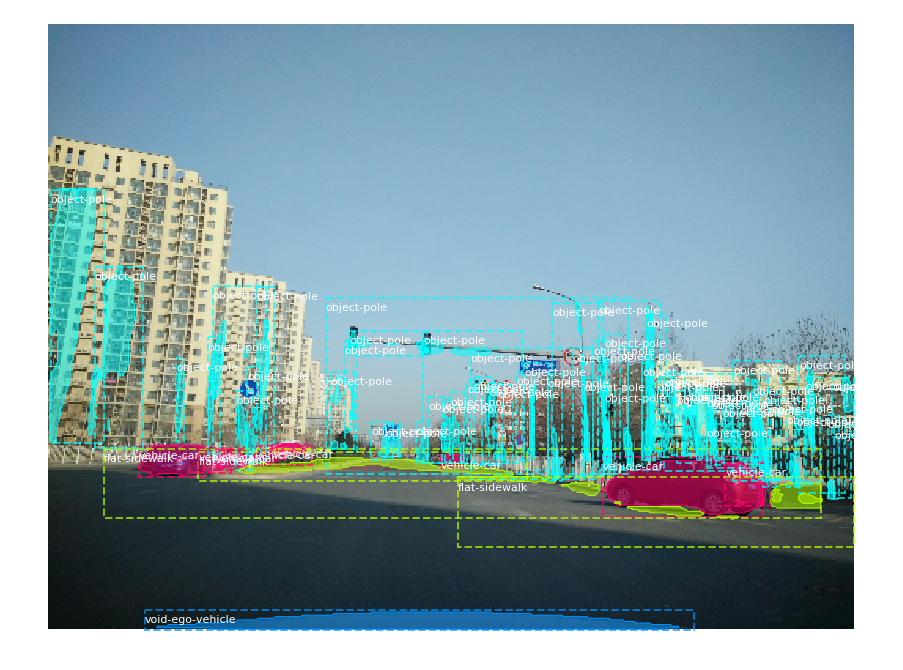

In [25]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(15,15))
    return ax

test_img = testData.load_image(1586)
results  = model.detect([test_img], verbose=1)
r = results[0]

if 'src.visualize' in sys.modules : del sys.modules['src.visualize']
import src.visualize as visualize
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                            testData.class_names, r['scores'], ax=get_ax())

# SCRATCHPAD

In [5]:
train_generator = modellib.data_generator_play(trainData)

In [8]:
"""
inputs = [input_image, input_image_meta,
                      input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
ops    = []
"""
ip, op = next(train_generator)


 -->  /home/ubuntu/datasets/open_datasets/mapillary_hdf5_16/mapillary-vistas-dataset_public_v1.0/training/570.h5


In [16]:
print ('Batch Size : ', len(ip[0]))
ip_split = []
with tf.Session() as sess:
    for each in ip:
        tmp = tf.split(each, 4)
        tmp2 = sess.run(tmp)
        print (each.shape, each.dtype, np.array(tmp2).shape)

Batch Size :  16
(16, 512, 512, 3) float32 (4, 4, 512, 512, 3)
(16, 23) int64 (4, 4, 23)
(16, 65472, 1) int32 (4, 4, 65472, 1)
(16, 256, 4) float64 (4, 4, 256, 4)
(16, 100) int32 (4, 4, 100)
(16, 100, 4) int32 (4, 4, 100, 4)
(16, 56, 56, 100) float64 (4, 4, 56, 56, 100)


In [33]:
# input_slices = {name: tf.split(x, self.gpu_count)
#                         for name, x in zip(self.inner_model.input_names,
#                                            self.inner_model.inputs)}
print (model.input_names)

AttributeError: 'MaskRCNN' object has no attribute 'input_names'